<a href="https://colab.research.google.com/github/idkcursed/internship/blob/main/project_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls "/content/drive/MyDrive/project_works"


tyre.v1i.yolov8


In [10]:
ZIP_PATH = "/content/drive/MyDrive/tyre.v1i.yolov8"  # change if it's in a subfolder
EXTRACT_DIR = "/content/tyre_dataset"

!mkdir -p "$EXTRACT_DIR"
!unzip "$ZIP_PATH" -d "$EXTRACT_DIR"


unzip:  cannot find or open /content/drive/MyDrive/tyre.v1i.yolov8, /content/drive/MyDrive/tyre.v1i.yolov8.zip or /content/drive/MyDrive/tyre.v1i.yolov8.ZIP.


In [11]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00


In [12]:
from ultralytics import YOLO

DATA_YAML = "/content/drive/MyDrive/project_works/tyre.v1i.yolov8/data.yaml"  # 👈 adjust if folder name differs

model = YOLO("yolov8n.pt")  # small, fast model to start

model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=640,
    batch=16
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/project_works/tyre.v1i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x784350263fb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [13]:
!cp -r runs/detect/train "/content/drive/MyDrive/project_works/"


detect


In [14]:
!cp -r runs/detect/train "/content/drive/MyDrive/tyre_training_run/"


In [2]:
import numpy as np

def iou(box1, box2):
    # box = [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter = inter_w * inter_h

    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = area1 + area2 - inter + 1e-6

    return inter / union

def filter_nested_boxes(results, conf_th=0.4, iou_th=0.6, area_ratio_th=0.7):
    """
    - Drops low-confidence boxes
    - Removes small boxes that lie inside much bigger boxes (inner ring of tyre)
    """
    boxes = results.boxes.xyxy.cpu().numpy()
    confs = results.boxes.conf.cpu().numpy()
    clss  = results.boxes.cls.cpu().numpy()

    # 1) filter by confidence
    mask = confs >= conf_th
    boxes, confs, clss = boxes[mask], confs[mask], clss[mask]

    if len(boxes) == 0:
        return boxes, confs, clss

    # 2) sort by area (biggest first)
    areas = (boxes[:,2]-boxes[:,0]) * (boxes[:,3]-boxes[:,1])
    order = np.argsort(-areas)  # descending

    kept_idxs = []
    for i in order:
        bi = boxes[i]
        ai = areas[i]
        drop = False
        for j in kept_idxs:
            bj = boxes[j]
            aj = areas[j]

            # if big overlap and this box is clearly smaller => likely inner hole
            if iou(bi, bj) > iou_th and ai < area_ratio_th * aj:
                drop = True
                break
        if not drop:
            kept_idxs.append(i)

    kept_idxs = np.array(kept_idxs, dtype=int)
    return boxes[kept_idxs], confs[kept_idxs], clss[kept_idxs]



0: 640x640 1 Inner_dia, 1 outer_dia, 12.4ms
Speed: 3.8ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


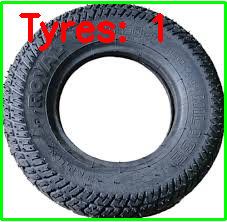

In [4]:
!pip install ultralytics opencv-python-headless

from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# ====== 1. EDIT THESE PATHS ======
MODEL_PATH = "/content/drive/MyDrive/tyre_training_run/weights/best.pt"   # your model
IMAGE_PATH = "/tyre1.jpg"               # your test image


# ====== 2. LOAD MODEL ======
model = YOLO(MODEL_PATH)

# ====== 3. READ IMAGE ======
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise ValueError("Image not found. Check IMAGE_PATH.")

# ====== 4. RUN YOLO ======
results = model(img)[0]

boxes_xyxy = results.boxes.xyxy.cpu().numpy() if len(results.boxes) else []
cls_ids    = results.boxes.cls.cpu().numpy() if len(results.boxes) else []

# ====== 5. COUNT ONLY OUTER_DIAMETER ======
tyre_count = 0
annotated = img.copy()

for i, box in enumerate(boxes_xyxy):
    class_id = int(cls_ids[i])
    label = results.names[class_id]    # "Inner_dia" or "outer_dia"

    if label != "outer_dia":           # ❗ ignore inner_dia
        continue

    tyre_count += 1

    # draw only outer_dia box
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(annotated, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(annotated, label, (x1, y1-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

# ====== 6. DISPLAY RESULT ======
cv2.putText(annotated, f"Tyres: {tyre_count}", (20,40),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3)

cv2_imshow(annotated)


In [9]:
!pip install ultralytics

from ultralytics import YOLO

# ========= 1. EDIT THESE PATHS =========
MODEL_PATH = "/content/drive/MyDrive/tyre_training_run/weights/best.pt"   # your trained model
VIDEO_PATH = "/content/drive/MyDrive/project_works/tyre2.mp4"                      # your long video


# ========= 2. LOAD MODEL =========
model = YOLO(MODEL_PATH)

# Set to speed up: process every Nth frame (vid_stride)
FRAME_STRIDE = 5   # 1 = every frame (slow, most accurate), 5 = every 5th frame (faster)

# ========= 3. TRACK & COUNT UNIQUE outer_dia IDS =========
unique_outer_ids = set()

print("Tracking tyres in video...")

for result in model.track(
    source=VIDEO_PATH,
    stream=True,            # return generator of results
    tracker="bytetrack.yaml",
    imgsz=640,
    vid_stride=FRAME_STRIDE,
    verbose=False
):
    boxes = result.boxes

    # If no detections in this frame, skip
    if boxes is None or len(boxes) == 0:
        continue

    # Track IDs (can be None for some frames at start)
    ids  = boxes.id
    clss = boxes.cls

    if ids is None:
        continue

    ids  = ids.cpu().tolist()
    clss = clss.cpu().tolist()

    for tid, c in zip(ids, clss):
        label = result.names[int(c)]   # class name like "Inner_dia" or "outer_dia"

        # ✅ Only count tyres by outer diameter
        if label != "outer_dia":
            continue

        # Add this track ID to the set (set avoids duplicates)
        unique_outer_ids.add(int(tid))

print("====================================")
print(f"Estimated UNIQUE tyres in video (outer_dia only): {len(unique_outer_ids)}")
print("====================================")


Tracking tyres in video...
Estimated UNIQUE tyres in video (outer_dia only): 0


In [9]:
from ultralytics import YOLO
import cv2
import math
from IPython.display import HTML
from base64 import b64encode

# ====== EDIT THESE PATHS ======
MODEL_PATH = "/content/drive/MyDrive/tyre_training_run/weights/best.pt"
VIDEO_PATH = "/content/drive/MyDrive/project_works/tyre5.webm"
OUTPUT_PATH = "/content/drive/MyDrive/project_works/output3.mp4"
# ===============================

# Load model
model = YOLO(MODEL_PATH)
print("Model classes:", model.names)

# Class ID for outer_dia
OUTER_DIA_CLASS_ID = 1   # change to 0 if your model swapped classes

cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError("Error opening video file!")

fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Video writer for output
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (w, h))

# Tracking variables
objects = {}     # id → {cx, last_cx}
next_id = 0
enter_count = 0
exit_count = 0

LINE_POS = 0.5      # vertical line at 50% width
MAX_DIST = 80       # tracking threshold
FRAME_SKIP = 1      # process every frame

frame_id = 0
print("Processing video, please wait...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1
    if frame_id % FRAME_SKIP != 0:
        continue

    line_x = int(w * LINE_POS)

    # YOLO detection
    results = model(frame, verbose=False)[0]
    boxes = results.boxes.xyxy.cpu().numpy() if len(results.boxes) else []
    clss  = results.boxes.cls.cpu().numpy() if len(results.boxes) else []

    detections = []
    for box, cls_id in zip(boxes, clss):
        if int(cls_id) != OUTER_DIA_CLASS_ID:
            continue

        x1, y1, x2, y2 = box
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        detections.append((cx, cy, x1, y1, x2, y2))

    new_objects = {}
    for cx, cy, x1, y1, x2, y2 in detections:
        assigned_id = None
        min_dist = float("inf")

        # Try to match with existing IDs
        for oid, info in objects.items():
            dist = math.hypot(cx - info['cx'], cy - info.get('cy', cy))
            if dist < min_dist and dist < MAX_DIST:
                assigned_id = oid
                min_dist = dist

        # New ID if unmatched
        if assigned_id is None:
            assigned_id = next_id
            next_id += 1
            last_cx = cx
        else:
            last_cx = objects[assigned_id]['cx']

        # Count ENTER (left → right)
        if last_cx < line_x <= cx:
            enter_count += 1

        # Count EXIT (right → left)
        if last_cx > line_x >= cx:
            exit_count += 1

        new_objects[assigned_id] = {'cx': cx, 'cy': cy}

        # Draw boxes on video
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)),
                      (0, 255, 0), 2)
        cv2.putText(frame, f"ID {assigned_id}", (int(x1), int(y1) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    objects = new_objects

    # Draw vertical line
    cv2.line(frame, (line_x, 0), (line_x, h), (0, 0, 255), 2)
    cv2.putText(frame, f"ENTER: {enter_count}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(frame, f"EXIT: {exit_count}", (20, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    # Write processed frame to output file
    writer.write(frame)

cap.release()
writer.release()

print("DONE! Video saved at:", OUTPUT_PATH)


Model classes: {0: 'Inner_dia', 1: 'outer_dia'}
Processing video, please wait...
DONE! Video saved at: /content/drive/MyDrive/project_works/output3.mp4
